In [3]:
import cv2 as cv
from typing import Any
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt

In [4]:
img = cv.imread('/Users/agerasymchuk/private_repo/cv_claude_course/cv_course/images/book.jpg')
# img = cv.cvtColor(img_, cv.COLOR_BGR2RGB)
h,w = img.shape[:2]
new_dim = (w//4, h//4)
print(new_dim)
resized = cv.resize(img, new_dim, interpolation=cv.INTER_CUBIC)
# cv.imwrite("/Users/agerasymchuk/private_repo/cv_claude_course/cv_course/images/book_small.jpg", resized)

(567, 756)


In [16]:
new_dim

(567, 756)

In [49]:
class AbstractTransformation:
    def __init__(self, img: cv.typing.MatLike):
        self.img = img
        self.width, self.height = img.shape[:2][::-1]
        self.min_distance = min(self.width, self.height) // 30
        
    
    def generate_points(self, method: str = 'triangular', density: int = 100) -> Any:
        pass

    def _pure_random_points(self, num_points: int) -> np.ndarray:
        rows = np.random.randint(0, self.height, size=num_points)
        cols = np.random.randint(0, self.width, size=num_points)
        return np.column_stack((cols, rows))
    
    def _constrained_random_points(num_points: int, distance: float) -> np.ndarray:
        pass

    def _create_triangulation(self, points: np.ndarray) -> np.ndarray:
        triangles = Delaunay(points)
        return triangles.simplices
    
    def visualize_triangulation(self, points: np.ndarray, triangles: np.ndarray) -> None:
        result = self.img.copy()
        for triangle in triangles:
            tri_points = points[triangle].astype(np.int32)
            cv.polylines(result, [tri_points], True, (0, 255, 0), 1)
        
        for point in points:
            cv.circle(result, tuple(point.astype(int)), 3, (255, 0, 0), -1)
        
        plt.figure(figsize=(10, 8))
        plt.imshow(result)
        plt.title(f'{len(points)} - points, {len(triangles)} - triangles')
        plt.axis('off')
        plt.show()

In [50]:
transformer = AbstractTransformation(resized)

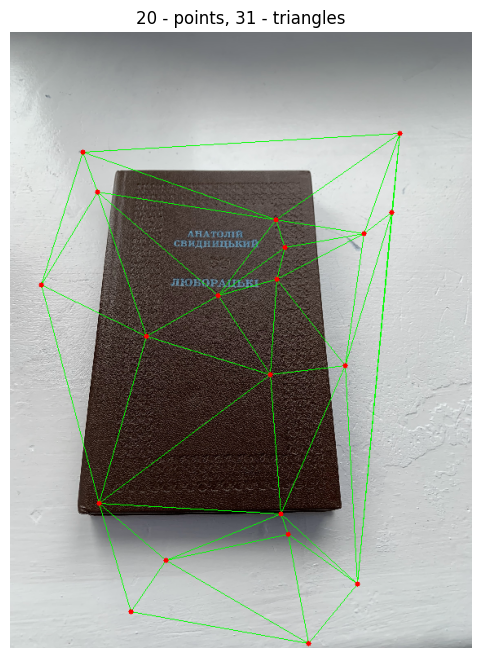

In [52]:
points = transformer._pure_random_points(20)
triangles = transformer._create_triangulation(points)
transformer.visualize_triangulation(points, triangles)



In [ ]:
def test__pure_random_points():
    transformer = AbstractTransformation(resized)
    assert all([x <=transformer.width and y <=transformer.height] for (x, y) in transformer._pure_random_points(10))

def test_create_triangulation():
    samples = 10
    transformer = AbstractTransformation(resized)
    points = transformer._pure_random_points(samples)
    triangles = transformer._create_triangulation(points)
    assert points.shape == (samples, 2)
    assert len(triangles) > len(points)
    assert len(triangles[0]) == 3




def run_tests():
    for k,v  in globals().items():
        if k.startswith('test_'):
            print(f'{k}...'); v()

    print('all tests passed')


run_tests()

test__pure_random_points...
test_create_triangulation...
all tests passed


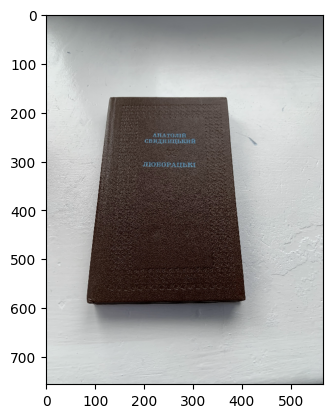

In [15]:
plt.imshow(resized)
plt.show()

In [26]:
resized.shape[:2][::-1]

(567, 756)